# MEWpy Optimization


Author: Vitor Pereira

License: [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0/)

-------

In this tutorial:

- You will learn how to run combinatorial optimization on microbial communities using MEWpy

## Bacterial cross-feeding via extensive gene loss

Metabolic dependencies between microbial species have a significant impact on the
assembly and activity of microbial communities. However, the evolutionary origins of
such dependencies and the impact of metabolic and genomic architecture on their
emergence are not clear.

Recently, [McNally et al.](https://doi.org/10.1186/s12918-018-0588-4) proposed a method to evolve
cooperative interactions among microbial species by fostering cross-feeding of a
diverse set of metabolites. This was achieved by incrementaly deleting genes on
initially two identical bacterias (E. coli) and increasingly imposing constraints on the
community metabolic network such that two new strains evolve and start to diverge
while maximizing the differences on their genotypes.

The aim is to replicate the experiments using
MEWpy to maximize the number of deleted genes on the two strains
while inducing cross-feeding. 

### Run in Google colab

If you are running this notebook in Colab, you need to perform the following steps, otherwise skip.

In [1]:
%%bash
[[ ! -e /colabtools ]] && exit
! pip install -U -q PyDrive

In [2]:
if 'google.colab' in str(get_ipython()):
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    model_file = drive.CreateFile({'id':'1o0XthuEOs28UJ4XTa9SfFSFofazV-2nN'})
    model_file.GetContentFile('e_coli_core.xml.gz')

## Step 1 - Load the model

In [3]:
from cobra.io import read_sbml_model
import warnings
warnings.filterwarnings('ignore')

model = read_sbml_model('models/ec/e_coli_core.xml.gz')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-11


We will make two copies of the model and rename the two strains

In [4]:
from mewpy import get_simulator
wildtype = get_simulator(model)

In [5]:
ec1 = wildtype.copy()
ec1.id = 'ec1'
ec2 =wildtype.copy()
ec2.id = 'ec2'

Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpj2gqys7h.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpau1cix46.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


In the experiment, we will use the medium defined in the model

In [6]:
from mewpy.simulation import Environment
medium = Environment.from_model(wildtype)
medium

,lb,ub
EX_ac_e,0.0,1000.0
EX_acald_e,0.0,1000.0
EX_akg_e,0.0,1000.0
EX_co2_e,-1000.0,1000.0
EX_etoh_e,0.0,1000.0
EX_for_e,0.0,1000.0
EX_fru_e,0.0,1000.0
EX_fum_e,0.0,1000.0
EX_glc__D_e,-10.0,1000.0
EX_gln__L_e,0.0,1000.0


## Step 2 - Find single strain gene KOs

Two make the search for combinatorial gene deletion on the community model, we will first idenfify combinatorial gene delerions in one strain, and use these results to seed the community gene deletions.

We start by defining a gene deletion optimization problem (`GKOProblem`) defining as objective the maximization of biomass production (f1) and the maximization of the number of deletions.

In [7]:
from mewpy.problems import GKOProblem
from mewpy.optimization.evaluation import TargetFlux, CandidateSize

In [8]:
f1 = TargetFlux(wildtype.biomass_reaction,method='FBA')
f2 = CandidateSize(maximize=True)

To simpilfy the problem, we will define a maximum of 30 gene deletion and run 10 optimization iterations.

In [9]:
problem = GKOProblem(wildtype,
                     [f1,f2],
                     candidate_max_size = 30)


In [10]:
from mewpy.optimization import EA
ea = EA(problem, max_generations=10)
gkos = ea.run(simplify=False)

Building modification target list.


100%|███████████████████████████████████████| 137/137 [00:00<00:00, 2767.45it/s]

Running NSGAII


Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpbbw_09mz.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp8yusets3.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpjvha3o4a.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpq9mluepc.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpe5ygabpr.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp_p7cpy6q.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/fold

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpyrzfoni9.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmppobh7638.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpxe6dnmr5.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmphaeeac_j.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmppil5vwwd.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp_uveeega.lp
Reading time = 0.00 seconds
: 72 rows, 1

Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpfo5tx0dq.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp5ujn2sqq.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpmdkdcjhv.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpq6qfr2bh.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpgupk217j.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpvwnwgfa5.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/fold

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpdyv8l1_m.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp35tofa00.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
   1000|  0.192520  0.873922  0.374230  0.529385  0.281540|  10.000000  30.000000  23.000000  22.980000  5.861706|


We can have a look to the solution found by the evolutionary algoritm (EA)

In [11]:
ea.dataframe()

,Modification,Size,TargetFlux,Size
0,"{'b0474': 0, 'b4122': 0, 'b1723': 0, 'b0809': ...",21,0.873922,21.0
1,"{'b1723': 0, 'b1676': 0, 'b0902': 0, 'b2458': ...",25,0.857802,25.0
2,"{'b3739': 0, 'b0474': 0, 'b4122': 0, 'b1479': ...",30,0.404116,30.0
3,"{'b4122': 0, 'b1723': 0, 'b0809': 0, 'b2458': ...",23,0.870745,23.0
4,"{'b1603': 0, 'b3951': 0, 'b0733': 0, 'b0474': ...",18,0.873922,18.0
...,...,...,...,...
70,"{'b3739': 0, 'b0474': 0, 'b1612': 0, 'b0902': ...",28,0.232589,28.0
71,"{'b3739': 0, 'b1723': 0, 'b3735': 0, 'b1676': ...",20,0.374230,20.0
72,"{'b0902': 0, 'b2458': 0, 'b1849': 0, 'b0767': ...",19,0.831485,19.0
73,"{'b2296': 0, 'b3951': 0, 'b2133': 0, 'b1702': ...",18,0.857802,18.0


and run an FBA on the first solution (the biomass is set by default as objective)

In [12]:
problem.simulate(solution=gkos[0].values)

objective: 0.8739215069684301
Status: OPTIMAL
Method:SimulationMethod.FBA

We may now generate solutions that will seed the EA to be used later in the community gene deletions.

In [13]:
import random

init_pop = []
for s in gkos:
    x=s.values
    init_pop.append([k+'_ec1' for k in x.keys()])
    init_pop.append([k+'_ec2' for k in x.keys()])

random.shuffle(init_pop)


## Community mutants 

We can now address our main goal, starting by defining a community model:

In [14]:
from mewpy.model import CommunityModel
from mewpy.com import regComFBA

community= CommunityModel([ec1,ec2],flavor='cobra')
sim = community.get_community_model()
sim.set_environmental_conditions(medium)

We will consider 3 optimization objectives:

- Maximize `ec1` growth while ensuring that `ec2` growth is above 0.1/h;
- Maximize `ec2` growth while ensuring that `ec1` growth is above 0.1/h;
- Maximize the total number of gene deletions.

We will be using a regularized Community FBA (regComFBA) to select a specific solution.

In [15]:
f1 = TargetFlux(community.organisms_biomass['ec1'],
                community.organisms_biomass['ec2'],
                min_biomass_value=0.1,method=regComFBA)

f2 = TargetFlux(community.organisms_biomass['ec2'],
                community.organisms_biomass['ec1'],
                min_biomass_value=0.1,method=regComFBA)

f3 = CandidateSize(maximize=True)

In [16]:
problem = GKOProblem(sim,
                     [f1,f2,f3],
                     candidate_max_size = 60)

Now that we have defined the optimization problem, we may run it (for 10 iterations, and considering a maximum of 60 gene deletions in total)

In [17]:
from mewpy.util.constants import EAConstants
EAConstants.DEBUG = True

ea = EA(problem,
        max_generations=10,
        initial_population=init_pop[:100])

solutions = ea.run(simplify=False)

Building modification target list.


100%|███████████████████████████████████████| 274/274 [00:00<00:00, 2512.33it/s]

Running NSGAII


Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp2lqltgc8.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp0wl5o5uj.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp2g8289nw.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp8w66t8b0.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set 

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpxukgf7cu.lp
Reading time = 0.00 seconds
: 125 r

Set parameter FeasibilityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp660gllz0.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set paramet

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpdk6w6iyu.lp
Set parameter FeasibilityTol to value 1e-09
Reading time = 0.00 seconds
Set parameter OptimalityTol to value 1e-09
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set paramet

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpnbh8pa8m.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set paramet

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Reading time = 0.00 seconds
Set parameter FeasibilityTol to value 1e-09
Read LP format 

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpmbopoit5.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set paramet

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp32qwada4.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp2eijq9wq.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpjcdpr_1y.lp
Reading time = 0.00 seconds
Set parameter FeasibilityTol to value 1e-09
: 125 rows, 342 columns, 1406 nonzeros
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to valu

Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp2uk44q_g.lp
Reading time = 0.00 seconds
Set parameter FeasibilityTol to value 1e-09
: 125 rows, 342 columns, 1406 nonzeros
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp1oc35nqm.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp93hgz2ct.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to valu

    800|  0.000000  0.710323  0.282503  0.362859  0.223748|  0.000000  0.707700  0.499578  0.414078  0.229769|  14.000000  43.000000  25.500000  26.000000  5.969925|
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpg1vzydgm.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp89t28ydk.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmphark6ilm.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpljcq2wpb.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpubdixiw8.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter Optimalit

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpcv1hkwso.lp
Reading time = 0.00 seconds
: 125 rows, 342 columns, 1406 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set paramet

We may now have a look at the solutions as a dataframe or as a plot

In [18]:
df = ea.dataframe()
df

,Modification,Size,TargetFlux,TargetFlux,Size
0,"{'b2133_ec1': 0, 'b1817_ec2': 0, 'b1241_ec2': ...",43,0.000000,0.000000,43.0
1,"{'b1241_ec2': 0, 'b2458_ec2': 0, 'b1817_ec2': ...",14,0.695486,0.127398,14.0
2,"{'b3731_ec1': 0, 'b1603_ec1': 0, 'b0728_ec1': ...",27,0.104982,0.707700,27.0
3,"{'b1241_ec2': 0, 'b3962_ec2': 0, 'b0726_ec2': ...",20,0.715589,0.107294,20.0
4,"{'b2133_ec1': 0, 'b0356_ec1': 0, 'b1603_ec1': ...",38,0.075862,0.000000,38.0
...,...,...,...,...,...
87,"{'b1101_ec2': 0, 'b0727_ec1': 0, 'b3731_ec1': ...",22,0.277046,0.545838,22.0
88,"{'b1241_ec2': 0, 'b3962_ec2': 0, 'b1812_ec2': ...",21,0.578158,0.244726,21.0
89,"{'b1817_ec2': 0, 'b1101_ec2': 0, 'b0734_ec2': ...",26,0.603937,0.218946,26.0
90,"{'b2133_ec1': 0, 'b3962_ec2': 0, 'b3213_ec1': ...",24,0.305166,0.514193,24.0


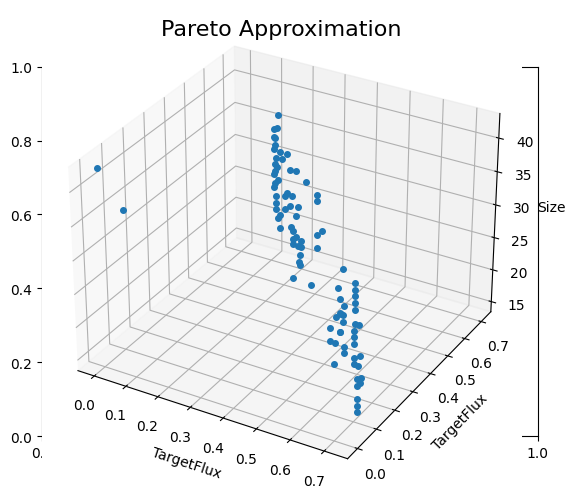

In [19]:
ea.plot()

We may even simulate one of the solution

In [20]:
solution = solutions[5]
solution

[0.37641902680049005, 0.4440292454531176, 20.0];{'b1854_ec2': 0, 'b3925_ec2': 0, 'b0724_ec1': 0, 'b3952_ec2': 0, 'b0902_ec1': 0, 'b4015_ec2': 0, 'b3612_ec1': 0, 'b2925_ec1': 0, 'b3925_ec1': 0, 'b3739_ec1': 0, 'b0351_ec2': 0, 'b0809_ec1': 0, 'b1524_ec1': 0, 'b1602_ec2': 0, 'b1852_ec1': 0, 'b1761_ec2': 0, 'b3114_ec1': 0, 'b1818_ec1': 0, 'b2976_ec2': 0, 'b3951_ec2': 0}

In [21]:
problem.simulate(solution=solution.values,method=regComFBA).find('BIOMASS',show_nulls=True)

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM_ec1,0.376419
BIOMASS_Ecoli_core_w_GAM_ec2,0.444029


or have a look to the reactions that were 'deleted'

In [22]:
problem.solution_to_constraints(solution.values)

{'SUCDi_ec1': 0,
 'THD2_ec2': 0,
 'GLUDy_ec2': 0,
 'G6PDH2r_ec1': 0,
 'ICL_ec2': 0,
 'GLNabc_ec1': 0,
 'FRUpts2_ec1': 0}